In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve

# Important Functions 

In [2]:
class logistic_regression(nn.Module):
    def __init__(self,in_dim):
        super().__init__()
        self.log_reg = nn.Sequential(
        nn.Linear(in_dim,1),
        nn.Sigmoid()    
        )
    def forward(self,x):
        return self.log_reg(x)
    
def train_log_reg(x_train, y_train, no_epochs = 100000, learn_rate = 0.1):
    # Define the model
    no_features = x_train.shape[1]
    model = logistic_regression(no_features)
    optimizer = torch.optim.Adam(model.parameters(), lr = learn_rate)
    criterion = nn.BCELoss()
    
    loss_all = []
    loss_prev = 1
    # Train the model
    for t in range(no_epochs):
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if np.abs(loss.item()-loss_prev)<1e-17:
            break
        
        loss_prev = loss.item()
        loss_all.append(loss.item())
    
    print('\nLoss on training set: ' + str(loss.item()))   
    plt.plot(loss_all)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()    
    return model, loss.item()

# Normalize data
def normalize_data(input_data):
    mu = input_data.mean(axis=0)
    std = input_data.std(axis=0)
    return (input_data-mu)/std, mu, std

# Evaluate the model
def evaluate_model(y_pred,y_test):
    y_output = y_pred
    y_output[y_output>=0.5]=1
    y_output[y_output<0.5]=0
        
    TP = np.sum(    y_output  *    y_test  )
    TN = np.sum( (1-y_output) * (1-y_test) )
    FP = np.sum(    y_output  * (1-y_test) )
    FN = np.sum( (1-y_output) *    y_test  )
    #print(str(TP)+' '+str(TN)+' '+str(FP)+' '+str(FN))        
    
    accuracy  = (TP+TN) / (TP+TN+FP+FN)
    recall    = TP / (TP+FN)
    precision = TP / (TP+FP)
    f1_score  = 2 * (precision * recall) / (precision + recall)
    print( ' -Accuracy: '  + str(accuracy)  )
    print( ' -Precision: ' + str(precision) )
    print( ' -Recall: '    + str(recall)    )
    print( ' -F1 score: '  + str(f1_score)  )
    
# Print the parameters of the PyTorch Linear Regression model
def print_parameters(model):
    for name, param in model.named_parameters():
        if name == 'log_reg.0.weight':
            print (' -Weights: '  + str(param.data.numpy().squeeze()), end = '; ')
        if name == 'log_reg.0.bias':
            print (' -Bias: '  + str(param.data.numpy().squeeze()), end = '; ')
        print()
    print()


# Loading data

In [3]:
# Import data
data = pd.read_csv('Admission_Predict_logits.csv')

# Feature names
print(data.columns)

# Show first 10 examples
data.head(10)

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,1
1,2,324,107,4,4.0,4.5,8.87,1,1
2,3,316,104,3,3.0,3.5,8.00,1,1
3,4,322,110,3,3.5,2.5,8.67,1,1
4,5,314,103,2,2.0,3.0,8.21,0,1
5,6,330,115,5,4.5,3.0,9.34,1,1
6,7,321,109,3,3.0,4.0,8.20,1,1
7,8,308,101,2,3.0,4.0,7.90,0,1
8,9,302,102,1,2.0,1.5,8.00,0,0
9,10,323,108,3,3.5,3.0,8.60,0,0


In [4]:
# Preparing data
x = torch.tensor(data.drop(['Serial No.', 'Chance of Admit '],axis=1).values).float()
y = torch.tensor(data['Chance of Admit ']).float().view(-1,1)

x_train_non_normalized, x_test_non_normalized, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state = 3)
x_train, mu, std = normalize_data(x_train_non_normalized)
x_test = ( x_test_non_normalized - mu )/std

# PyTorch Logistic Regression model


Loss on training set: 0.2446504533290863


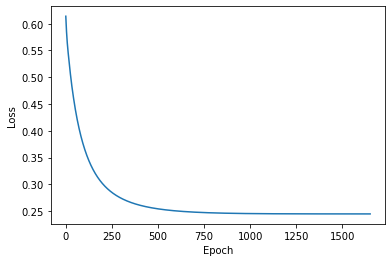

Training set:
 -Loss: 0.24465036
 -Accuracy: 0.9125
 -Precision: 0.9271137
 -Recall: 0.9695122
 -F1 score: 0.9478390139768242

Test set:
 -Loss: 0.26003158
 -Accuracy: 0.92
 -Precision: 0.91358024
 -Recall: 0.9866667
 -F1 score: 0.9487179953659959


In [5]:
# Train the model without regularization
model, loss = train_log_reg(x_train, y_train, learn_rate = 0.01)

# Evaluate the model on train set
y_pred_train = model(x_train)

print('Training set:')
criterion = nn.BCELoss()
loss = criterion(y_pred_train, y_train).data.numpy().squeeze()
print( ' -Loss: '      + str(loss) )
evaluate_model(y_pred_train.data.numpy(), y_train.data.numpy())


# Evaluate the model on test set
y_pred_test = model(x_test)

print('\nTest set:')
criterion = nn.BCELoss()
loss = criterion(y_pred_test, y_test).data.numpy().squeeze()
print( ' -Loss: ' + str(loss) )
evaluate_model(y_pred_test.data.numpy(), y_test.data.numpy())

In [6]:
print('Parameters of the PyTorch model:')
print_parameters(model)

Parameters of the PyTorch model:
 -Weights: [0.3557783  0.24137706 0.0677684  0.21948367 0.33005366 2.027229
 0.27477995]; 
 -Bias: 3.3979394; 



# Scikit-learn Logistic Regression model

In [7]:
# Instantiating the model and training
log_reg_sklearn = LogisticRegression( penalty='none' )
log_reg_sklearn.fit(x_train, y_train.data.numpy().ravel())

# Evaluating the sklearn model
print('Training set:')
evaluate_model( log_reg_sklearn.predict(x_train).reshape(-1,1), y_train.data.numpy() )

print('Test set:')
evaluate_model( log_reg_sklearn.predict(x_test).reshape(-1,1), y_test.data.numpy() )

Training set:
 -Accuracy: 0.9125
 -Precision: 0.9271137
 -Recall: 0.9695122
 -F1 score: 0.9478390139768242
Test set:
 -Accuracy: 0.92
 -Precision: 0.91358024
 -Recall: 0.9866667
 -F1 score: 0.9487179953659959


In [8]:
print('Parameters of the Scikit-learn model:')
print(' -Weights: ' + str( log_reg_sklearn.coef_.squeeze()) )
print(' -Bias: ' + str( log_reg_sklearn.intercept_.squeeze()) )

Parameters of the Scikit-learn model:
 -Weights: [0.35865352 0.24336895 0.07052297 0.22031169 0.33247953 2.04399319
 0.27729448]
 -Bias: 3.42722123060512


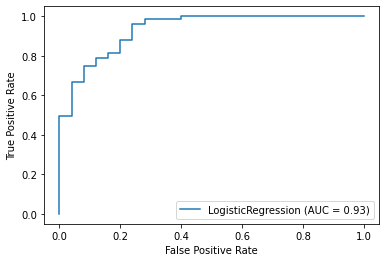

In [9]:
# ROC curve for the sklearn Logistic Regression model
plot_roc_curve(log_reg_sklearn, x_test, y_test)